# Cruise Planning: GeoSpatial Map Superimposed by Arbitrary Cruise Trajectories

<a href="https://colab.research.google.com/github/simonscmap/pycmap/blob/master/docs/CruisePlan.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

This notebook demonstrates how to create a geospatial map using a gridded dataset and overlay a number of custom cruise tracks. To create this visualization, you need to specify the background map dataset and provide one or more cruise trajectory files to be superimposed on the background map. The cruise trajectory file should be in csv format with two columns (lat, and lon) indicating the cruise trajectory coordinates. The trajectory files do not require date/time columns. If you wish to add a new cruise track on top of the background map, just create a new trajectory file, put it in the `./cruises/` directory, and run the code again.<br/>

Visualizations like this can help to plan a prospective cruise expedition and identify an optimal cruise path according to the scientific objectives. In fact, this notebook has been used by Dr. Virgina Armbrust in preparation for the TN397 cruise expedition to evaluate multiple different cruise scenarios. In this notebook, the background map is set to the concentration of dissolved Nitrate estimated by the [Pisces](https://simonscmap.com/catalog/datasets/Mercator_Pisces_Biogeochem_Climatology) dataset (see the [Main](#Main) section: `table="tblPisces_NRT"`, `variable="no3"`). To change the background map, simply replace the `table`, and `variable` names with your desired values. The full list of all tables and variables in Simons CMAP can be found in the [catalog](https://simonscmap.com/catalog). The overlaid cruise trajectories have been prepared by Dr. Virginia Armbrust representing candidate cruise tracks for the TN397 expedition.<br/>

**Note:**  you need to register and get an API Key from [SimonsCMAP](https://simonscmap.com) to be able to run this notebook.

## Dependencies
Install and import the required dependencies, including pycmap & cartopy libraries.  

In [4]:
# uncomment the following lines to install cartopy and pycmap in the Google's Colab environment (may take a few minutes).
# !pip uninstall shapely -y
# !pip install --no-binary shapely shapely --force
# !pip install cartopy pycmap -q


import os, glob
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycmap
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

## Helper functions

In [8]:
def cruise_tracks():
    """
    Return cruise track filenames. The cruise tracks must be stored in csv files with 2 columns: `lat`, `lon`.  
    These csv files must be located at `./cruises/` directory. If no cruise tracks are found, some sample tracks are downloaded. 
    """
    try:
        cruiseDir = "./cruises"
        if len(glob.glob(f"./cruises/*.csv")) < 1: 
            os.makedirs(cruiseDir)
            urlretrieve("https://raw.githubusercontent.com/simonscmap/pycmap/master/docs/cruises/Scenario1.csv", f"{cruiseDir}/Scenario1.csv")
            urlretrieve("https://raw.githubusercontent.com/simonscmap/pycmap/master/docs/cruises/Scenario2.csv", f"{cruiseDir}/Scenario2.csv")
            urlretrieve("https://raw.githubusercontent.com/simonscmap/pycmap/master/docs/cruises/Scenario3.csv", f"{cruiseDir}/Scenario3.csv")
    except Exception as e:
        print(f"Error in downloading sample cruise files:\n{str(e)}")
        return []
    return glob.glob(f"./cruises/*.csv")


def get_background(API_KEY, table, variable, dt1, dt2, lat1, lat2, lon1, lon2, depth1, depth2):
    """
    Retrieve the background that the cruise trajectory will be plotted against. 
    The output will be a dataframe containing the table name, and the variable values.
    
    Ouputs:
    df: background field dataframe (pandas dataframe)
    variable: variable short name (string)
    longName: variable long name (string)
    unit: variable unit (string)

    Note: You'll need to include your own API key to call the pycmap api. 
    You can learn how to get an API key here: https://simonscmap.com/apikeymanagement.    
    """
    api = pycmap.API(token=API_KEY)
    longName = api.get_var_long_name(table, variable)
    unit = api.get_unit(table, variable)
    df = api.space_time(
                    table=table,
                    variable=variable,
                    dt1=dt1,
                    dt2=dt2,
                    lat1=lat1,
                    lat2=lat2,
                    lon1=lon1,
                    lon2=lon2,
                    depth1=depth1,
                    depth2=depth2
                    )
    return df, variable, longName, unit


def cartopy_map(cruiseFiles, df, variable, title):
    """
    Generates maps using the cartopy library. The user-specified variable will be plotted on a globe and 
    the cruise trajectories will be superimposed on the background map.
    """

    fig = plt.figure(figsize=(10, 10))
    plt.clf()
    lat = df.lat.unique()
    lon = df.lon.unique()
    shape = (len(lat), len(lon))
    data = df[variable].values.reshape(shape)
    ## remove the gap on lon: 180deg
    data[:, 0] = data[:, 2]
    data[:, 1] = data[:, 2]
    lon[-1] = 180
    
    
    
    # Set the orientation and tilt of the globe.
    # The current tilt/orientation vaulues (eg., central_longitude= -130 and central_latitude=5) center the globe in the Pacific Ocean around the equator. 
    # Change these values to center the globe in your region of choice. 
    #################################
    ax = plt.axes(projection=ccrs.NearsidePerspective(central_longitude=-130, 
                                                      central_latitude=5, 
                                                      satellite_height=35785831, 
                                                      false_easting=0, 
                                                      false_northing=0))

    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND)
    ax.add_feature(cf.LAKES)

    
    # Set the color scale and color palette for the background image.  
    # The scale can be set either by entering desired max, min scales or by using a quantile scale.  
    # The quantile option is included here with min, max option commented out with #. 
    # Simply remove/add # to switch between the two options. 
    ################################
    LON, LAT = np.meshgrid(lon, lat)  
    quant = 0.1
    im = ax.pcolormesh(LON, 
                       LAT, 
                       data, 
                       transform=ccrs.PlateCarree(),
                       vmin=np.nanquantile(np.array(data).flatten(), quant), 
                       vmax=np.nanquantile(np.array(data).flatten(), 1-quant), 
                       #vmin=0,
                       #vmax=15,
                       cmap=cmocean.cm.thermal,
                       alpha=1
                       )

    
    # Set the color, line vs points, and point size for the cruise trajectory.  
    # A number of different sample colors have been included here. If you plot one cruise, the first color in the list will be chosen. If you plot two cruises, the first two colors in the list will be chosen, etc. 
    # The user can switch between line vs points. The default is line, with the indication for points commented out. The size of the points can be changed by chaning the number associated with marker size.
    ######################################

    colors = ["dodgerblue", "orangered","springgreen", "gold", "deeppink",  "mediumslateblue", "gray", "cyan", "g", "r",  "springgreen", "silver", "k"  ]
    for ind, f in enumerate(cruiseFiles):
        track = pd.read_csv(f)
        plt.plot(
                track["lon"], 
                track["lat"], 
                '--', 
                #(-) is a line, (o) are points
                markersize=2,
                linewidth=3,
                markeredgewidth=0, 
                color=colors[ind % len(colors)],
                label=f.split(".csv")[0].split("/")[-1],
                alpha=0.9, 
                transform=ccrs.PlateCarree()
                )

        
    # Set the labels.    
    ######################################
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=False,
                      linewidth=.2, 
                      color="k", 
                      alpha=0.5, 
                      linestyle=":"
                      )

    gl.xlocator = mticker.FixedLocator(np.arange(-180.,240.,60.))
    gl.ylocator = mticker.FixedLocator(np.arange(-90.,120.,30.))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xlabel_style = {"size": 6, "color": "k"}
    gl.ylabel_style = {"size": 6, "color": "k"}

    if len(cruiseFiles) > 0: plt.legend(fontsize=10, markerscale=3, loc=1)
    ax.set_title(title)
    cbar = fig.colorbar(im, fraction=0.04, pad=0.04, orientation="horizontal")
    cbar.ax.tick_params(labelsize=7)
    plt.show()
    plt.close()
    return

<br/><br/><br/><br/><br/>
## Main

The main function of the code sets the dataset that will be used as the background and retrieves the cruise trajectories from your ./cruises directory. 
Remember the trajectories within this directory are csv files with `lat`, and `lon` columns. 
Some example cruise trajectory files have been alreay created by Dr. Virginia Armbrust in preparation for a cruise expedition which may be found [here](https://github.com/simonscmap/pycmap/tree/master/docs/cruises). 
The figure will be saved as a .png file with the same name as the variable used as the background. 
The table, variable names (plus more details) can be found in the Simons CMAP catalog page (https://simonscmap.com/catalog). 
The dates, lat, lon, and depth range are defined by the user. Make sure the dates you choose contain data by checking the date range of your dataset. 

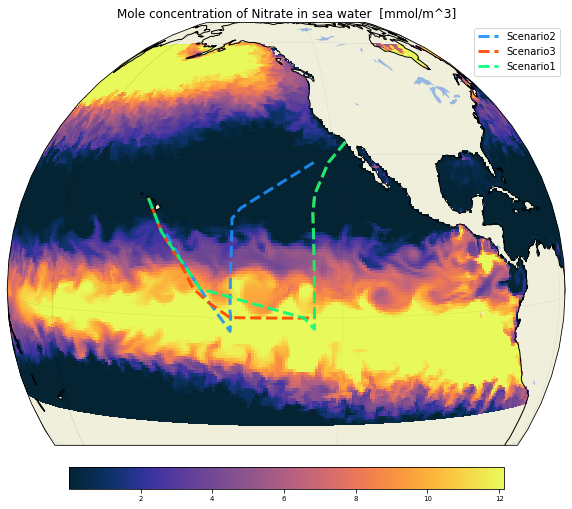

In [16]:
API_KEY = "YOUR_API_KEY"
cruiseFiles = cruise_tracks()  
if len(cruiseFiles) < 1: print("No cruise trajectory file found.\nPlease add a cruise trajectory file (csv file with lat, and lon columns) to the ./cruises directory.")
df, variable, longName, unit = get_background(
                                              API_KEY=API_KEY,  
                                              table="tblPisces_NRT",
                                              variable="no3",
                                              dt1="2018-01-20",
                                              dt2="2018-01-20",
                                              lat1=-20,
                                              lat2=60,
                                              lon1=-180,
                                              lon2=180,
                                              depth1=0,
                                              depth2=0.5    
                                              )

cartopy_map(cruiseFiles, df, variable, title=f"{longName} {unit}")